# BLIP: Inference Demo
 - [Image Captioning](#Image-Captioning)


In [2]:
# install requirements
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install transformers==4.34.0.dev0 timm==0.4.12 fairscale==0.4.4
    !git clone https://github.com/salesforce/BLIP
    %cd BLIP

In [13]:
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_demo_image(image_size,device):
    img_path = '/home/ayesha.ishaq/Downloads/val/8/f/0/3/8f03819576.jpg'
    # raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   
    raw_image = Image.open(img_path).convert('RGB')   

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))
    
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    image = transform(raw_image).unsqueeze(0).to(device)   
    return image

# Image Captioning
Perform image captioning using finetuned BLIP model

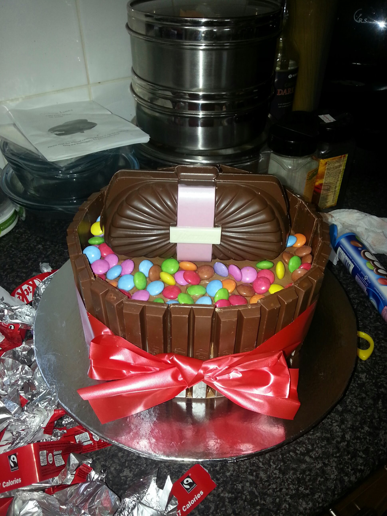

load checkpoint from /home/ayesha.ishaq/Desktop/AI701/CookBookCreater/checkpoint_6.pth
caption:  amies m m chocolate cake


In [14]:
from models.blip import blip_decoder

image_size = 384
image = load_demo_image(image_size=image_size, device=device)

# model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
model_url = "/home/ayesha.ishaq/Desktop/AI701/CookBookCreater/checkpoint_6.pth"
    
model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base', prompt='')
model.eval()
model = model.to(device)

with torch.no_grad():
    # beam search
    # caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
    # nucleus sampling
    caption = model.generate(image, sample=True, top_p=0.90, max_length=8, min_length=1) 
    print('caption: ',caption[0])

In [1]:
import LLaMa

generator_llama = LLaMa.RecipeGenerator()
recipe_llama = generator_llama.generate(text='amies m m chocolate cake')
recipe_llama

/home/ayesha.ishaq/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-24 01:06:29.752909: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-24 01:06:29.787549: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-24 01:06:29.875547: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropr

"  Amie's M&M's Chocolate Cake Recipe:\n\nIngredient List:\n\n* 2 cups all-purpose flour\n* 1 cup granulated sugar\n* 1/2 cup unsweetened cocoa powder\n* 1 teaspoon baking powder\n* 1 teaspoon salt\n* 1/2 cup unsalted butter, softened\n* 2 large eggs\n* 2 teaspoons vanilla extract\n* 1 cup M&M's miniballs (or other small chocolate candies)\n\nRecipe Steps:\n\n1. Preheat the oven to 350°F (180°C). Grease two 9-inch (23cm) round cake pans and line the bottoms with parchment paper.\n2. In a medium bowl, whisk together the flour, sugar, cocoa powder, baking powder, and salt.\n3. In a large mixing bowl, use an electric mixer to beat the butter and sugar until light and fluffy, about 2 minutes.\n4. Beat in the eggs one at a time, followed by the vanilla extract.\n5. Gradually mix in the dry ingredients until just combined, being careful not to overmix.\n6. Fold in the M&M's miniballs (or other small chocolate candies) evenly throughout the batter.\n7. Divide the batter evenly between the pre

In [2]:
recipe_llama = generator_llama.generate(text='brownies')
recipe_llama

'  Sure, here is a recipe for classic brownies:\n\nIngredient List:\n\n* 1 and 1/2 sticks of unsalted butter (12 tablespoons), plus more for greasing the pan\n* 2 cups of sugar\n* 4 large eggs\n* 1/2 cup of unsweetened cocoa powder\n* 1 teaspoon of vanilla extract\n* 1/4 teaspoon of salt\n* 1 and 1/4 cups of all-purpose flour\n* 1 cup of semi-sweet chocolate chips\n\nRecipe Steps:\n\n1. Preheat your oven to 350°F (180°C). Grease an 8-inch square baking pan and line it with parchment paper.\n2. Melt the butter and sugar in a medium saucepan over medium heat, stirring occasionally, until the butter is melted and the sugar is dissolved.\n3. Remove the saucepan from the heat and stir in the cocoa powder until it is well combined.\n4. Let the mixture cool slightly, then stir in the eggs one at a time, followed by the vanilla extract.\n5. In a separate bowl, whisk together the flour and salt. Add the flour mixture to the saucepan and stir until just combined.\n6. Stir in the chocolate chips.

In [6]:
import os
result_path_v = os.path.join('./output/', 'result_recipe_llama_cake.txt')

with open(result_path_v, 'w') as f:
    f.write(recipe_llama)

In [3]:
import Vicuna

generator_vicuna = Vicuna.RecipeGenerator()
recipe_vicuna = generator_vicuna.generate(text='amies m m chocolate cake')
recipe_vicuna

Loading checkpoint shards: 100%|██████████| 2/2 [00:21<00:00, 10.73s/it]
/home/ayesha.ishaq/.conda/envs/aiproject/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/home/ayesha.ishaq/.conda/envs/aiproject/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect 

KeyboardInterrupt: 

In [3]:
import os
result_path_v = os.path.join('./output/', 'result_recipe_vicuna_cake.txt')

with open(result_path_v, 'w') as f:
    f.write(recipe_vicuna)